In [26]:
!pip install transformers

In [27]:

# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
logging.basicConfig(level=logging.ERROR)
device = 'cuda' if cuda.is_available() else 'cpu'


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:

# Load dataset
df_org = pd.read_csv('/content/dataset-1000.csv')
df_org.head()


,Unnamed: 0,title,content,time,category,subreddit,score,upvote_ratio
0,0,NaN,Aug 14 2022 Four major cruise lines are facin...,NaN,imposter content,vicuna,NaN,NaN
1,1,Belgium approves four-day week and gives emplo...,The package of labour reforms announced on Tue...,2022-02-15 00:00:00,TRUE,UpliftingNews,106414.0,0.93
2,2,Trump Received Millions From Foreign Governmen...,"The transactions, detailed in a 156-page repor...",2024-01-04 00:00:00,TRUE,neutralnews,1.0,1.00
3,3,Conspiracy Theorist Claims That Government Run...,"AUSTIN, TEXAS – Conspiracy theorists are known...",2022-07-28 00:00:00,satire,satire,17.0,1.00
4,4,‘The Onion’ Stands With Israel Because It Seem...,The past week has shown humanity at its worst:...,2023-10-13 14:54:00.505000+00:00,satire,satire,1.0,1.00


In [30]:
category_mapping = {
    'TRUE': 0,
    'satire': 1,
    'misleading content': 2,
    'imposter content': 3
}

In [31]:
df_input= pd.DataFrame()
df_input['content'] = df_org['title'] + '\n'  + df_org['content']
df_input['category'] = df_org['category'].map(category_mapping)
df_input.head()
print(type(df_input.content))

<class 'pandas.core.series.Series'>


In [32]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')



# Ensure the content column is a string and handle NaN values
df_input['content'] = df_input['content'].astype(str).fillna('')

# Remove punctuation
# df_input['content'] = df_input['content'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Remove URLs
df_input['content'] = df_input['content'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))

# Remove stop words
# stop_words = set(stopwords.words('english'))
# df_input['content'] = df_input['content'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Lowercase the text
df_input['content'] = df_input['content'].apply(lambda x: x.lower())

# Initialize stemmer and lemmatizer
# stemmer = PorterStemmer()
# lemmatizer = WordNetLemmatizer()

# Perform stemming
# df_input['content'] = df_input['content'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Perform lemmatization
# df_input['content'] = df_input['content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Display the first row's content
print(df_input.iloc[0]['content'])

# Display the first few rows of the DataFrame
df_input.head()


nan


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,content,category
0,nan,3
1,belgium approves four-day week and gives emplo...,0
2,trump received millions from foreign governmen...,0
3,conspiracy theorist claims that government run...,1
4,‘the onion’ stands with israel because it seem...,1


   category  count
0         0    284
1         3    270
2         2    270
3         1    264


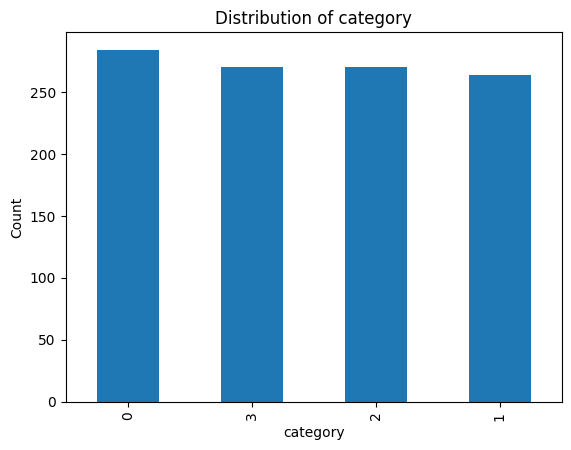

In [33]:
category_column = 'category'


# Show the category-wise distribution
distribution = df_input[category_column].value_counts().reset_index()
distribution.columns = [category_column, 'count']

print(distribution)

# Plot the distribution as a bar chart


distribution.plot(kind='bar', x=category_column, y='count', legend=False)
plt.title(f'Distribution of {category_column}')
plt.xlabel(category_column)
plt.ylabel('Count')
plt.show()

In [34]:

# Define key variables
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-5
tokenizer = RobertaTokenizer.from_pretrained('roberta-large', truncation=True, do_lower_case=True)


In [35]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.content
        self.targets = self.data.category
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        if index >= len(self.data):
          raise IndexError("Index out of range")
        text = str(self.text[index])
        text = " ".join(text.split())

        text_inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )

        text_ids = text_inputs['input_ids']
        text_mask = text_inputs['attention_mask']
        text_token_type_ids = text_inputs["token_type_ids"]



        return {
            'text_ids': torch.tensor(text_ids, dtype=torch.long),
            'text_mask': torch.tensor(text_mask, dtype=torch.long),
            'text_token_type_ids': torch.tensor(text_token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [36]:

# Split the dataset
train_data, test_data = train_test_split(df_input, test_size=0.2, stratify=df_input['category'])
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


In [37]:

# Prepare dataloaders
train_dataset = SentimentData(train_data, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_dataset = SentimentData(test_data, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE, shuffle=True)


In [38]:

# Define model training and evaluation functions
def train_model(model, train_loader, epochs):
    model.train()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
    loss_function = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        tr_loss = 0
        for _, data in tqdm(enumerate(train_loader, 0)):
            text_ids = data['text_ids'].to(device, dtype=torch.long)
            text_mask = data['text_mask'].to(device, dtype=torch.long)
            text_token_type_ids = data['text_token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)
            outputs = model(
                text_ids=text_ids,
                text_mask=text_mask,
                text_token_type_ids=text_token_type_ids
            ).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()




In [39]:
# def evaluate_model(model, test_loader, test_data):
#     model.eval()
#     predictions = []
#     with torch.no_grad():
#         for _, data in tqdm(enumerate(test_loader, 0)):
#             text_ids = data['text_ids'].to(device, dtype=torch.long)
#             text_mask = data['text_mask'].to(device, dtype=torch.long)
#             text_token_type_ids = data['text_token_type_ids'].to(device, dtype=torch.long)
#             outputs = model(
#                 text_ids=text_ids,
#                 text_mask=text_mask,
#                 text_token_type_ids=text_token_type_ids
#             ).squeeze()
#             big_val, big_idx = torch.max(outputs.data, dim=1)
#             predictions.extend(big_idx.cpu().numpy())

#     test_data['predicted_category'] = predictions
#     return test_data

In [40]:
def evaluate_model(model, test_loader, test_data):
    predictions = []
    with torch.no_grad():
        for _, data in tqdm(enumerate(test_loader, 0)):
            text_ids = data['text_ids'].to(device, dtype=torch.long)
            text_mask = data['text_mask'].to(device, dtype=torch.long)
            text_token_type_ids = data['text_token_type_ids'].to(device, dtype=torch.long)

            outputs = model(
                text_ids=text_ids,
                text_mask=text_mask,
                text_token_type_ids=text_token_type_ids
            ) # Removed squeeze() as it is likely flattening the output to a single dimension
            # Check the shape of the output to confirm
            print("Shape of outputs:", outputs.shape)

            # If outputs is 2D, proceed with finding max
            if len(outputs.shape) == 2:
                big_val, big_idx = torch.max(outputs.data, dim=1)
                predictions.extend(big_idx.cpu().numpy())
            else:
                print("Model output is not 2D. Check model architecture.")

    test_data['predictions'] = predictions
    return test_data

In [41]:

# Define the evaluation function
def evaluate(y_true, y_pred):
    labels = ['TRUE', 'satire', 'misleading content', 'imposter content', 'none']
    mapping = {'TRUE': 1, 'satire': 2, 'misleading content': 3, 'imposter content': 4, 'none': 5}

    def map_func(x):
        return mapping.get(x, 5)

    # y_true = np.vectorize(map_func)(y_true)
    # y_pred = np.vectorize(map_func)(y_pred)

    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    unique_labels = set(y_true)

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true)) if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')

    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)

    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2, 3, 4])
    print('\nConfusion Matrix:')
    print(conf_matrix)


In [42]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-large")
        self.pre_classifier = torch.nn.Linear(1024, 768)  # Adjusted for combined inputs
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, text_ids, text_mask, text_token_type_ids):
        text_output = self.l1(input_ids=text_ids, attention_mask=text_mask, token_type_ids=text_token_type_ids)


        text_hidden_state = text_output[0]

        pooler = text_hidden_state[:, 0]

        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [43]:

# Initialize model
model = RobertaClass()
model.to(device)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm):

In [44]:
# Train and evaluate
train_model(model, train_loader, EPOCHS)

0it [00:00, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
168it [59:49, 21.14s/it]

In [45]:
test_data_with_predictions = evaluate_model(model, test_loader, test_data)
test_data_with_predictions.head()

3it [00:00,  9.81it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


7it [00:00, 13.15it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


11it [00:00, 14.79it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


13it [00:00, 15.39it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


17it [00:01, 15.81it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


21it [00:01, 13.97it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


25it [00:01, 14.79it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


29it [00:02, 15.34it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


31it [00:02, 15.57it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


35it [00:02, 15.55it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


39it [00:02, 16.00it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


43it [00:02, 16.24it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


47it [00:03, 15.71it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


51it [00:03, 15.80it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


55it [00:03, 16.33it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


59it [00:03, 16.47it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


63it [00:04, 16.48it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


67it [00:04, 16.41it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


71it [00:04, 16.45it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


75it [00:04, 15.76it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


77it [00:05, 15.59it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


81it [00:05, 15.83it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


85it [00:05, 15.83it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


89it [00:05, 16.27it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


93it [00:06, 16.54it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


97it [00:06, 16.22it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


101it [00:06, 15.61it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


105it [00:06, 16.12it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


109it [00:07, 15.52it/s]

Shape of outputs: torch.Size([2, 5])
Shape of outputs: torch.Size([2, 5])


,content,category,predictions
0,25 beautiful girl names nobody has used (yet)\...,2,1
1,"i, matt damon, apologize for last year’s crypt...",1,0
2,petition to change ‘irish potato famine’ to ‘b...,1,1
3,nan,3,1
4,hunter dies after elephant falls on him\njohan...,0,0


In [46]:
test_data_with_predictions.head()

,content,category,predictions
0,25 beautiful girl names nobody has used (yet)\...,2,1
1,"i, matt damon, apologize for last year’s crypt...",1,0
2,petition to change ‘irish potato famine’ to ‘b...,1,1
3,nan,3,1
4,hunter dies after elephant falls on him\njohan...,0,0


In [47]:
# Evaluate the results
evaluate(test_data_with_predictions['category'], test_data_with_predictions['predictions'])

Accuracy: 0.307
Accuracy for label 0: 0.386
Accuracy for label 1: 0.264
Accuracy for label 2: 0.333
Accuracy for label 3: 0.241

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.39      0.35        57
           1       0.35      0.26      0.30        53
           2       0.33      0.33      0.33        54
           3       0.24      0.24      0.24        54

    accuracy                           0.31       218
   macro avg       0.31      0.31      0.31       218
weighted avg       0.31      0.31      0.31       218


Confusion Matrix:
[[22  7 13 15  0]
 [16 14  9 14  0]
 [16  7 18 13  0]
 [14 12 15 13  0]
 [ 0  0  0  0  0]]
